# Futures Spread Dynamics Analysis

**Name:** Dafu Zhu  
**Student ID:** 12504076  
**Date Range:** December 12, 2025 - December 19, 2025

## Overview

This notebook analyzes calendar spread dynamics for two pairs of futures contracts:

1. **Pair 1 (Energy):** CL (Crude Oil Light Sweet) versus HO (Heating Oil)
2. **Pair 2 (Equity Indices):** YM (Micro E-Mini Dow Jones) versus RTY (E-Mini Russell 2000)

For each pair, we calculate the calendar spread (second month - front month) and analyze:
- Statistical properties (mean, median, standard deviation, quantiles)
- Deviations from rolling averages
- Cross-spread correlations

## 1. Setup and Imports

In [1]:
# Import required libraries
import os
from dotenv import load_dotenv
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Configuration and Parameters

In [2]:
# Load WRDS credentials
load_dotenv()
WRDS_USERNAME = os.getenv("WRDS_USERNAME")
WRDS_PASSWORD = os.getenv("WRDS_PASSWORD")

# Analysis parameters
START_DATE = '2025-12-12'
END_DATE = '2025-12-19'  # Third Friday of December 2025
ROLLING_WINDOWS = [3, 5, 10, 20]  # N-day rolling windows for analysis

# Contract codes mapping (Thomson Reuters Datastream)
CONTRACT_MAPPING = {
    'CL': 1986,   # Crude Oil (Light Sweet)
    'HO': 2029,   # Heating Oil (New York)
    'YM': 4712,   # Micro E-Mini Dow Jones
    'RTY': 4396   # CME E-mini Russell 2000
}

print(f"Analysis Period: {START_DATE} to {END_DATE}")
print(f"Rolling Windows: {ROLLING_WINDOWS}")
print(f"\nFutures Contracts:")
for ticker, code in CONTRACT_MAPPING.items():
    print(f"  {ticker}: contrcode {code}")

Analysis Period: 2025-12-12 to 2025-12-19
Rolling Windows: [3, 5, 10, 20]

Futures Contracts:
  CL: contrcode 1986
  HO: contrcode 2029
  YM: contrcode 4712
  RTY: contrcode 4396


## 3. Connect to WRDS Database

In [3]:
# Connect to WRDS
print("Connecting to WRDS...")
db = wrds.Connection(wrds_username=WRDS_USERNAME, wrds_password=WRDS_PASSWORD)
print("✓ Connected successfully!")

Connecting to WRDS...
Loading library list...
Done
✓ Connected successfully!


## 4. Data Download Functions

In [4]:
def download_futures_data(db, ticker, start_date, end_date):
    """
    Download futures data from WRDS Thomson Reuters Datastream.
    
    Args:
        db: WRDS database connection
        ticker: Futures ticker symbol ('CL', 'HO', 'YM', 'RTY')
        start_date: Start date for data
        end_date: End date for data
    
    Returns:
        DataFrame with futures data including contract info
    """
    print(f"\nDownloading data for {ticker}...")
    
    if ticker not in CONTRACT_MAPPING:
        print(f"Unknown ticker: {ticker}")
        return None
    
    contrcode = CONTRACT_MAPPING[ticker]
    
    # Query to get all contracts for this ticker that overlap with our date range
    query = f"""
    SELECT
        c.futcode,
        c.contrcode,
        c.dsmnem,
        c.contrname,
        c.lasttrddate,
        c.expirationdate,
        c.startdate,
        v.date_,
        v.open_,
        v.high,
        v.low,
        v.settlement as close,
        v.volume,
        v.openinterest
    FROM tr_ds_fut.wrds_contract_info c
    INNER JOIN tr_ds_fut.wrds_fut_contract v ON c.futcode = v.futcode
    WHERE c.contrcode = {contrcode}
    AND v.date_ >= '{start_date}'
    AND v.date_ <= '{end_date}'
    AND c.startdate <= '{end_date}'
    AND c.lasttrddate >= '{start_date}'
    ORDER BY v.date_, c.lasttrddate
    """
    
    try:
        df = db.raw_sql(query)
        df = df.rename(columns={'date_': 'date', 'open_': 'open'})
        print(f"  ✓ Downloaded {len(df)} rows")
        print(f"  ✓ Found {df['futcode'].nunique()} unique contracts")
        print(f"  ✓ Date range: {df['date'].min()} to {df['date'].max()}")
        return df
    except Exception as e:
        print(f"  ✗ Error downloading {ticker}: {e}")
        return None

print("✓ Data download function defined")

✓ Data download function defined


## 5. Data Processing Functions

In [5]:
def identify_top_contracts(df, n_contracts=2):
    """
    Identify the top N contracts by number of data points.
    
    Args:
        df: DataFrame with futures data
        n_contracts: Number of contracts to identify (default=2 for front and second month)
    
    Returns:
        List of futcodes for top contracts
    """
    if df is None or len(df) == 0:
        return []
    
    # Count rows per contract (futcode)
    contract_counts = df.groupby('futcode').agg({
        'date': 'count',
        'dsmnem': 'first',
        'lasttrddate': 'first'
    }).rename(columns={'date': 'count'})
    contract_counts = contract_counts.sort_values('count', ascending=False)
    
    print(f"\n  Top {n_contracts} contracts by data points:")
    print(contract_counts.head(n_contracts))
    
    top_contracts = contract_counts.head(n_contracts).index.tolist()
    return top_contracts


def prepare_contract_data(df, futcode, start_date, end_date):
    """
    Prepare data for a specific contract with forward-fill.
    
    Args:
        df: DataFrame with futures data
        futcode: Futcode of the contract
        start_date: Start date string
        end_date: End date string
    
    Returns:
        Series with close prices, forward-filled for missing dates
    """
    if df is None or futcode is None:
        return None
    
    contract_data = df[df['futcode'] == futcode].copy()
    if len(contract_data) == 0:
        print(f"  ✗ Warning: No data for futcode {futcode}")
        return None
    
    # Ensure date column is datetime without time component
    contract_data['date'] = pd.to_datetime(contract_data['date']).dt.date
    contract_data = contract_data.set_index('date')['close'].sort_index()
    
    # Create full date range (as date objects, not datetime)
    date_range = pd.date_range(start=start_date, end=end_date, freq='D').date
    contract_data = contract_data.reindex(date_range)
    
    # Forward fill on days where data exists
    contract_data = contract_data.ffill()
    
    print(f"  ✓ Futcode {futcode}: {contract_data.notna().sum()} data points")
    
    return contract_data


def calculate_calendar_spread(second_month, front_month):
    """
    Calculate calendar spread: second_month - front_month.
    
    Args:
        second_month: Series with second month prices
        front_month: Series with front month prices
    
    Returns:
        Series with spread values
    """
    if second_month is None or front_month is None:
        return None
    
    spread = second_month - front_month
    return spread

print("✓ Data processing functions defined")

✓ Data processing functions defined


## 6. Download Data for All Futures

We download minute-level futures data from WRDS for the analysis period.

In [6]:
# Download data for all four futures
print("="*80)
print("DOWNLOADING FUTURES DATA")
print("="*80)

cl_data = download_futures_data(db, 'CL', START_DATE, END_DATE)
ho_data = download_futures_data(db, 'HO', START_DATE, END_DATE)
ym_data = download_futures_data(db, 'YM', START_DATE, END_DATE)
rty_data = download_futures_data(db, 'RTY', START_DATE, END_DATE)

print("\n" + "="*80)
print("✓ All data downloaded successfully!")
print("="*80)

DOWNLOADING FUTURES DATA

  ✓ Downloaded 804 rows
  ✓ Found 134 unique contracts
  ✓ Date range: 2025-12-12 to 2025-12-19

  ✓ Downloaded 294 rows
  ✓ Found 49 unique contracts
  ✓ Date range: 2025-12-12 to 2025-12-19

  ✓ Downloaded 26 rows
  ✓ Found 5 unique contracts
  ✓ Date range: 2025-12-12 to 2025-12-19

  ✓ Downloaded 67 rows
  ✓ Found 12 unique contracts
  ✓ Date range: 2025-12-12 to 2025-12-19

✓ All data downloaded successfully!


## 7. Identify Front and Second Month Contracts

According to the assignment instructions, we select the two contracts with the most data points as front month and second month.

In [7]:
print("="*80)
print("IDENTIFYING CONTRACTS")
print("="*80)

print("\nCL (Crude Oil):")
cl_contracts = identify_top_contracts(cl_data, n_contracts=2)

print("\nHO (Heating Oil):")
ho_contracts = identify_top_contracts(ho_data, n_contracts=2)

print("\nYM (Dow Mini):")
ym_contracts = identify_top_contracts(ym_data, n_contracts=2)

print("\nRTY (Russell 2000 Mini):")
rty_contracts = identify_top_contracts(rty_data, n_contracts=2)

IDENTIFYING CONTRACTS

CL (Crude Oil):

  Top 2 contracts by data points:
          count   dsmnem lasttrddate
futcode                             
349339.0      6  NCL1226  2026-11-20
417159.0      6  NCL0233  2033-01-20

HO (Heating Oil):

  Top 2 contracts by data points:
          count   dsmnem lasttrddate
futcode                             
417987.0      6  NHO0126  2025-12-31
479097.0      6  NHO0728  2028-06-30

YM (Dow Mini):

  Top 2 contracts by data points:
          count   dsmnem lasttrddate
futcode                             
479860.0      6  CDU1225  2025-12-19
483904.0      6  CDU0326  2026-03-20

RTY (Russell 2000 Mini):

  Top 2 contracts by data points:
          count   dsmnem lasttrddate
futcode                             
475081.0      6  IRM1225  2025-12-19
479866.0      6  IRM0326  2026-03-20


## 8. Prepare Contract Data with Forward-Fill

For sparse contracts, we forward-fill prices on days where data exists (as per assignment instructions).

In [8]:
print("="*80)
print("PREPARING CONTRACT DATA")
print("="*80)

# CL contracts
print("\nCL (Crude Oil):")
cl_front = prepare_contract_data(cl_data, cl_contracts[0], START_DATE, END_DATE) if len(cl_contracts) > 0 else None
cl_second = prepare_contract_data(cl_data, cl_contracts[1], START_DATE, END_DATE) if len(cl_contracts) > 1 else None

# HO contracts
print("\nHO (Heating Oil):")
ho_front = prepare_contract_data(ho_data, ho_contracts[0], START_DATE, END_DATE) if len(ho_contracts) > 0 else None
ho_second = prepare_contract_data(ho_data, ho_contracts[1], START_DATE, END_DATE) if len(ho_contracts) > 1 else None

# YM contracts
print("\nYM (Dow Mini):")
ym_front = prepare_contract_data(ym_data, ym_contracts[0], START_DATE, END_DATE) if len(ym_contracts) > 0 else None
ym_second = prepare_contract_data(ym_data, ym_contracts[1], START_DATE, END_DATE) if len(ym_contracts) > 1 else None

# RTY contracts
print("\nRTY (Russell 2000 Mini):")
rty_front = prepare_contract_data(rty_data, rty_contracts[0], START_DATE, END_DATE) if len(rty_contracts) > 0 else None
rty_second = prepare_contract_data(rty_data, rty_contracts[1], START_DATE, END_DATE) if len(rty_contracts) > 1 else None

PREPARING CONTRACT DATA

CL (Crude Oil):
  ✓ Futcode 349339.0: 8 data points
  ✓ Futcode 417159.0: 8 data points

HO (Heating Oil):
  ✓ Futcode 417987.0: 8 data points
  ✓ Futcode 479097.0: 8 data points

YM (Dow Mini):
  ✓ Futcode 479860.0: 8 data points
  ✓ Futcode 483904.0: 8 data points

RTY (Russell 2000 Mini):
  ✓ Futcode 475081.0: 8 data points
  ✓ Futcode 479866.0: 8 data points


## 9. Calculate Calendar Spreads

Calendar spread = Second Month Price - Front Month Price

We calculate two spreads:
- **s¹(t)**: CL second month - CL front month
- **s²(t)**: YM second month - YM front month

In [9]:
print("="*80)
print("CALCULATING CALENDAR SPREADS")
print("="*80)

# Calculate spreads
cl_spread = calculate_calendar_spread(cl_second, cl_front)
ym_spread = calculate_calendar_spread(ym_second, ym_front)

# Display basic info
if cl_spread is not None:
    print(f"\n✓ CL calendar spread: {cl_spread.notna().sum()} data points")
    print(f"  Mean: ${cl_spread.mean():.2f}")
    print(f"  Range: ${cl_spread.min():.2f} to ${cl_spread.max():.2f}")

if ym_spread is not None:
    print(f"\n✓ YM calendar spread: {ym_spread.notna().sum()} data points")
    print(f"  Mean: ${ym_spread.mean():.2f}")
    print(f"  Range: ${ym_spread.min():.2f} to ${ym_spread.max():.2f}")

CALCULATING CALENDAR SPREADS

✓ CL calendar spread: 8 data points
  Mean: $5.70
  Range: $5.54 to $5.95

✓ YM calendar spread: 8 data points
  Mean: $365.38
  Range: $332.00 to $386.00


## 10. Spread Time Series Visualization

Plot the calendar spreads over time to observe their dynamics.

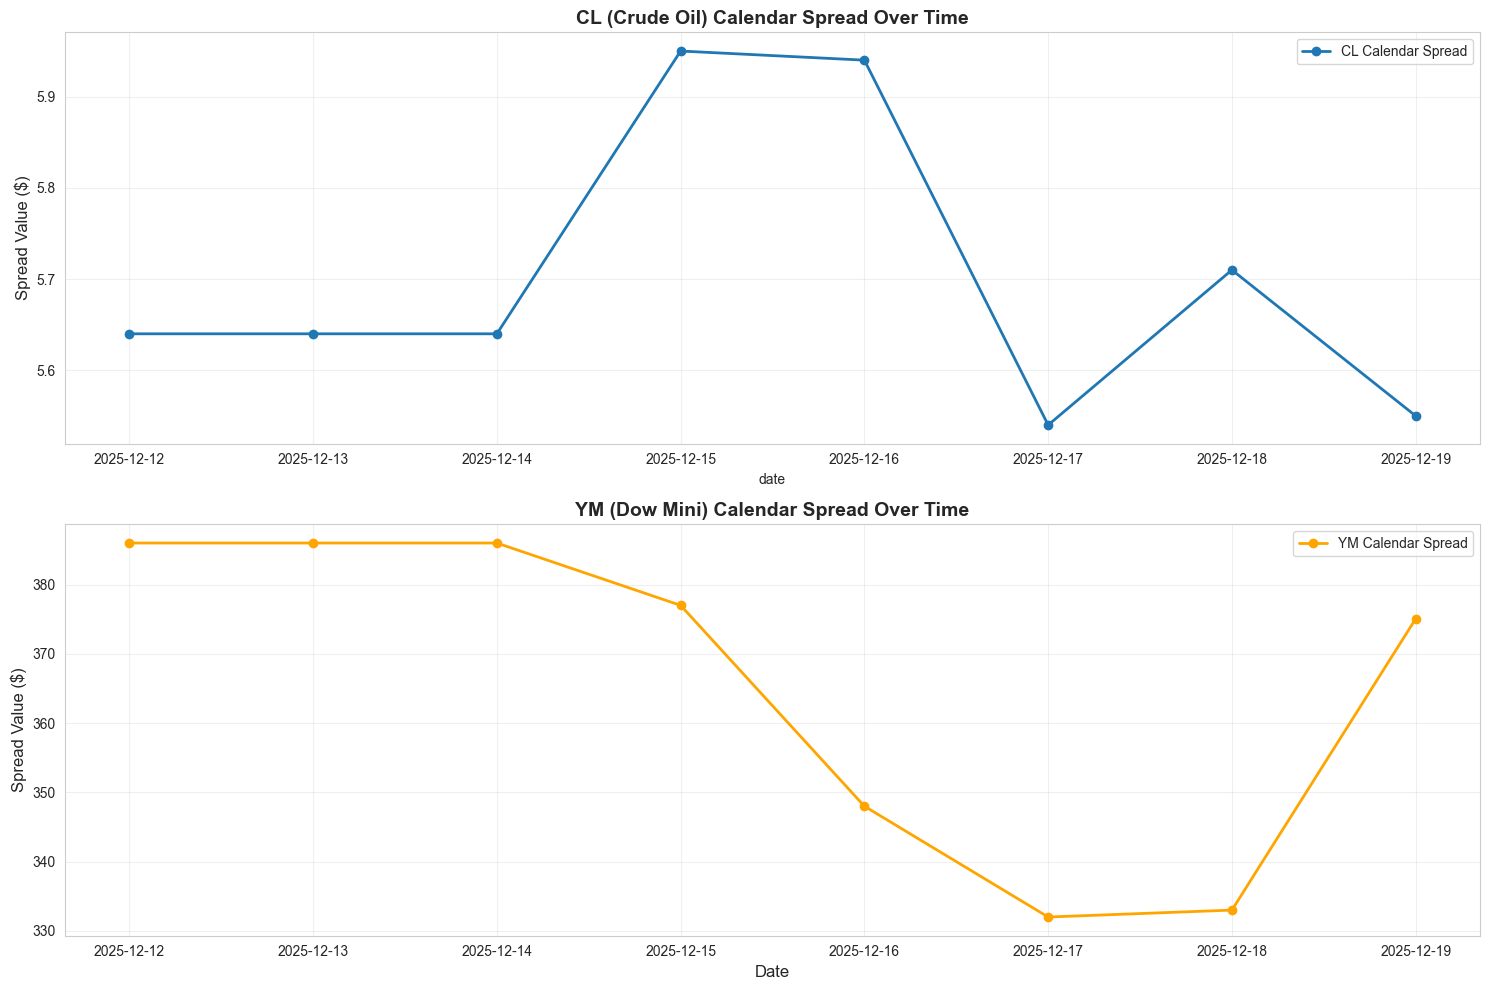


💾 Figure saved as: output/spreads_timeseries.png


In [10]:
# Create time series plot
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# CL spread
if cl_spread is not None:
    cl_spread.plot(ax=axes[0], label='CL Calendar Spread', linewidth=2, marker='o')
    axes[0].set_title('CL (Crude Oil) Calendar Spread Over Time', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Spread Value ($)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# YM spread
if ym_spread is not None:
    ym_spread.plot(ax=axes[1], label='YM Calendar Spread', linewidth=2, marker='o', color='orange')
    axes[1].set_title('YM (Dow Mini) Calendar Spread Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Spread Value ($)', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/spreads_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Figure saved as: output/spreads_timeseries.png")

### Observations:
- **CL Spread**: Shows the difference between second and front month crude oil futures
- **YM Spread**: Shows the difference between second and front month Dow Mini futures
- The time series reveals spread patterns and volatility over the analysis period

## 11. Statistical Analysis Functions

In [11]:
def analyze_spread_dynamics(spread, label, rolling_windows):
    """
    Analyze spread dynamics with rolling averages and deviations.
    
    Args:
        spread: Series with spread values
        label: Label for the spread
        rolling_windows: List of window sizes for rolling averages
    
    Returns:
        Dictionary with analysis results
    """
    if spread is None or len(spread) == 0:
        return None
    
    results = {
        'label': label,
        'spread': spread,
        'stats': {},
        'deviations': {}
    }
    
    # Basic statistics
    results['stats']['mean'] = spread.mean()
    results['stats']['median'] = spread.median()
    results['stats']['std'] = spread.std()
    results['stats']['min'] = spread.min()
    results['stats']['max'] = spread.max()
    results['stats']['quantiles'] = spread.quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
    
    # Rolling average deviations for different N values
    for N in rolling_windows:
        rolling_avg = spread.rolling(window=N, min_periods=1).mean()
        deviation = spread - rolling_avg
        
        results['deviations'][f'd_{N}'] = {
            'values': deviation,
            'median': deviation.median(),
            'std': deviation.std(),
            'quantiles': deviation.quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
        }
    
    return results


def analyze_cross_spread_dynamics(spread1, spread2, rolling_windows):
    """
    Analyze dynamics between two spreads.
    
    Args:
        spread1: First spread series
        spread2: Second spread series
        rolling_windows: List of window sizes
    
    Returns:
        Dictionary with cross-analysis results
    """
    results = {
        'correlation': None,
        'd_correlations': {}
    }
    
    if spread1 is None or spread2 is None:
        return results
    
    # Correlation between spreads
    results['correlation'] = spread1.corr(spread2)
    
    # Correlations between deviation values
    for N in rolling_windows:
        rolling_avg1 = spread1.rolling(window=N, min_periods=1).mean()
        deviation1 = spread1 - rolling_avg1
        
        rolling_avg2 = spread2.rolling(window=N, min_periods=1).mean()
        deviation2 = spread2 - rolling_avg2
        
        results['d_correlations'][f'd_{N}'] = deviation1.corr(deviation2)
    
    return results

print("✓ Statistical analysis functions defined")

✓ Statistical analysis functions defined


## 12. Compute Statistics for Both Spreads

Calculate comprehensive statistics including:
- Basic statistics (mean, median, std, min, max)
- Quantiles (1%, 5%, 25%, 50%, 75%, 95%, 99%)
- Deviations from N-day rolling averages (N = 3, 5, 10, 20)

In [12]:
print("="*80)
print("STATISTICAL ANALYSIS")
print("="*80)

# Analyze CL spread
print("\nAnalyzing CL spread...")
results_cl = analyze_spread_dynamics(cl_spread, 'CL Calendar Spread', ROLLING_WINDOWS)

# Analyze YM spread
print("Analyzing YM spread...")
results_ym = analyze_spread_dynamics(ym_spread, 'YM Calendar Spread', ROLLING_WINDOWS)

# Cross-spread analysis
print("Analyzing cross-spread correlations...")
cross_results = analyze_cross_spread_dynamics(cl_spread, ym_spread, ROLLING_WINDOWS)

print("\n✓ Statistical analysis complete!")

STATISTICAL ANALYSIS

Analyzing CL spread...
Analyzing YM spread...
Analyzing cross-spread correlations...

✓ Statistical analysis complete!


## 13. Display Summary Statistics

### CL (Crude Oil) Spread Statistics

In [13]:
if results_cl:
    print("="*80)
    print("CL (CRUDE OIL) CALENDAR SPREAD - BASIC STATISTICS")
    print("="*80)
    print(f"Mean:     ${results_cl['stats']['mean']:.6f}")
    print(f"Median:   ${results_cl['stats']['median']:.6f}")
    print(f"Std Dev:  ${results_cl['stats']['std']:.6f}")
    print(f"Min:      ${results_cl['stats']['min']:.6f}")
    print(f"Max:      ${results_cl['stats']['max']:.6f}")
    print("\nQuantiles:")
    for q, val in results_cl['stats']['quantiles'].items():
        print(f"  {q*100:5.1f}%: ${val:.6f}")

CL (CRUDE OIL) CALENDAR SPREAD - BASIC STATISTICS
Mean:     $5.701250
Median:   $5.640000
Std Dev:  $0.159950
Min:      $5.540000
Max:      $5.950000

Quantiles:
    1.0%: $5.540700
    5.0%: $5.543500
   25.0%: $5.617500
   50.0%: $5.640000
   75.0%: $5.767500
   95.0%: $5.946500
   99.0%: $5.949300


### YM (Dow Mini) Spread Statistics

In [14]:
if results_ym:
    print("="*80)
    print("YM (DOW MINI) CALENDAR SPREAD - BASIC STATISTICS")
    print("="*80)
    print(f"Mean:     ${results_ym['stats']['mean']:.6f}")
    print(f"Median:   ${results_ym['stats']['median']:.6f}")
    print(f"Std Dev:  ${results_ym['stats']['std']:.6f}")
    print(f"Min:      ${results_ym['stats']['min']:.6f}")
    print(f"Max:      ${results_ym['stats']['max']:.6f}")
    print("\nQuantiles:")
    for q, val in results_ym['stats']['quantiles'].items():
        print(f"  {q*100:5.1f}%: ${val:.6f}")

YM (DOW MINI) CALENDAR SPREAD - BASIC STATISTICS
Mean:     $365.382500
Median:   $376.030000
Std Dev:  $23.811861
Min:      $332.000000
Max:      $386.000000

Quantiles:
    1.0%: $332.070000
    5.0%: $332.350000
   25.0%: $344.250000
   50.0%: $376.030000
   75.0%: $386.000000
   95.0%: $386.000000
   99.0%: $386.000000


## 14. Spread Distribution Visualization

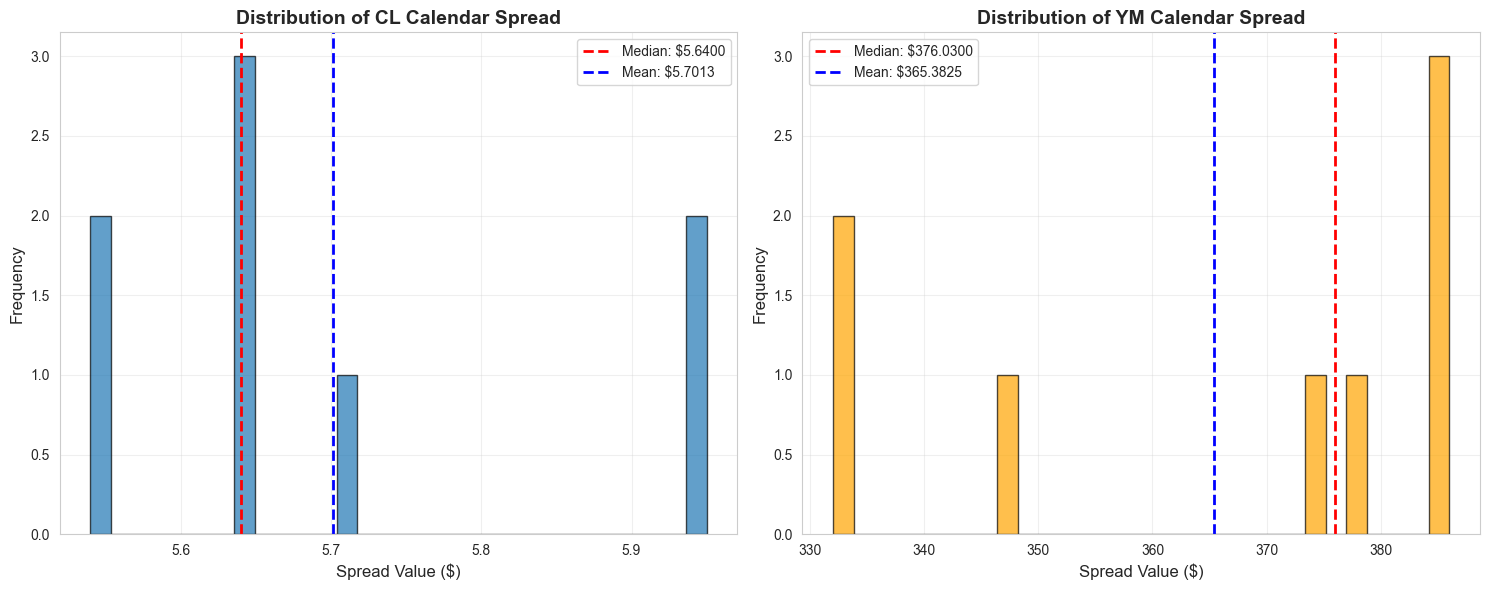


💾 Figure saved as: output/spreads_distribution.png


In [15]:
# Create distribution plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# CL distribution
if results_cl:
    axes[0].hist(results_cl['spread'].dropna(), bins=30, alpha=0.7, edgecolor='black')
    axes[0].axvline(results_cl['stats']['median'], color='red', linestyle='--',
                   linewidth=2, label=f"Median: ${results_cl['stats']['median']:.4f}")
    axes[0].axvline(results_cl['stats']['mean'], color='blue', linestyle='--',
                   linewidth=2, label=f"Mean: ${results_cl['stats']['mean']:.4f}")
    axes[0].set_title('Distribution of CL Calendar Spread', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Spread Value ($)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# YM distribution
if results_ym:
    axes[1].hist(results_ym['spread'].dropna(), bins=30, alpha=0.7,
                color='orange', edgecolor='black')
    axes[1].axvline(results_ym['stats']['median'], color='red', linestyle='--',
                   linewidth=2, label=f"Median: ${results_ym['stats']['median']:.4f}")
    axes[1].axvline(results_ym['stats']['mean'], color='blue', linestyle='--',
                   linewidth=2, label=f"Mean: ${results_ym['stats']['mean']:.4f}")
    axes[1].set_title('Distribution of YM Calendar Spread', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Spread Value ($)', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/spreads_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Figure saved as: output/spreads_distribution.png")

### Observations:
- The histograms show the distribution of spread values
- Red dashed line indicates the median
- Blue dashed line indicates the mean
- The shape of the distribution reveals whether spreads are normally distributed or skewed

## 15. Rolling Average Deviation Analysis

For each spread, we calculate deviations from N-day rolling averages to identify patterns and mean-reversion tendencies.

### CL Spread Deviations

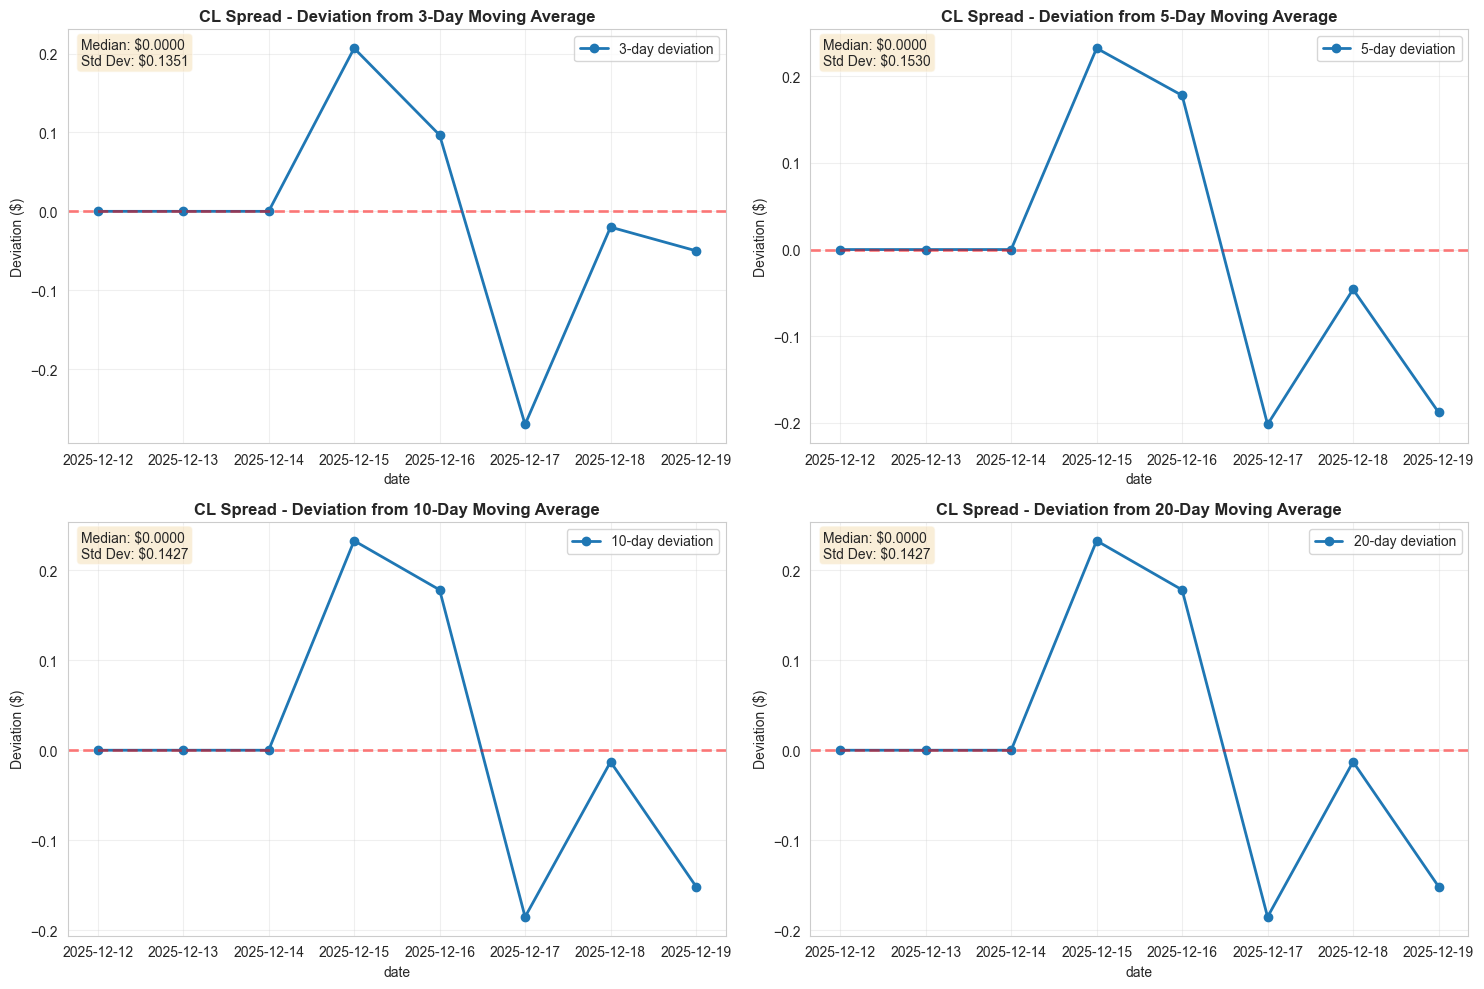


💾 Figure saved as: output/spread1_deviations.png


In [16]:
if results_cl and results_cl['deviations']:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, N in enumerate(ROLLING_WINDOWS):
        if f'd_{N}' in results_cl['deviations']:
            dev_data = results_cl['deviations'][f'd_{N}']['values']
            dev_data.plot(ax=axes[idx], label=f'{N}-day deviation', linewidth=2, marker='o')
            axes[idx].axhline(0, color='red', linestyle='--', alpha=0.5, linewidth=2)
            axes[idx].set_title(f"CL Spread - Deviation from {N}-Day Moving Average",
                              fontsize=12, fontweight='bold')
            axes[idx].set_ylabel('Deviation ($)', fontsize=10)
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
            
            # Add statistics as text
            stats_text = f"Median: ${results_cl['deviations'][f'd_{N}']['median']:.4f}\n"
            stats_text += f"Std Dev: ${results_cl['deviations'][f'd_{N}']['std']:.4f}"
            axes[idx].text(0.02, 0.98, stats_text, transform=axes[idx].transAxes,
                          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('output/spread1_deviations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n💾 Figure saved as: output/spread1_deviations.png")

### Interpretation:
- Each subplot shows deviations from a different moving average window
- Positive values: spread is above its moving average
- Negative values: spread is below its moving average
- Mean reversion is indicated by returns to the zero line

### YM Spread Deviations

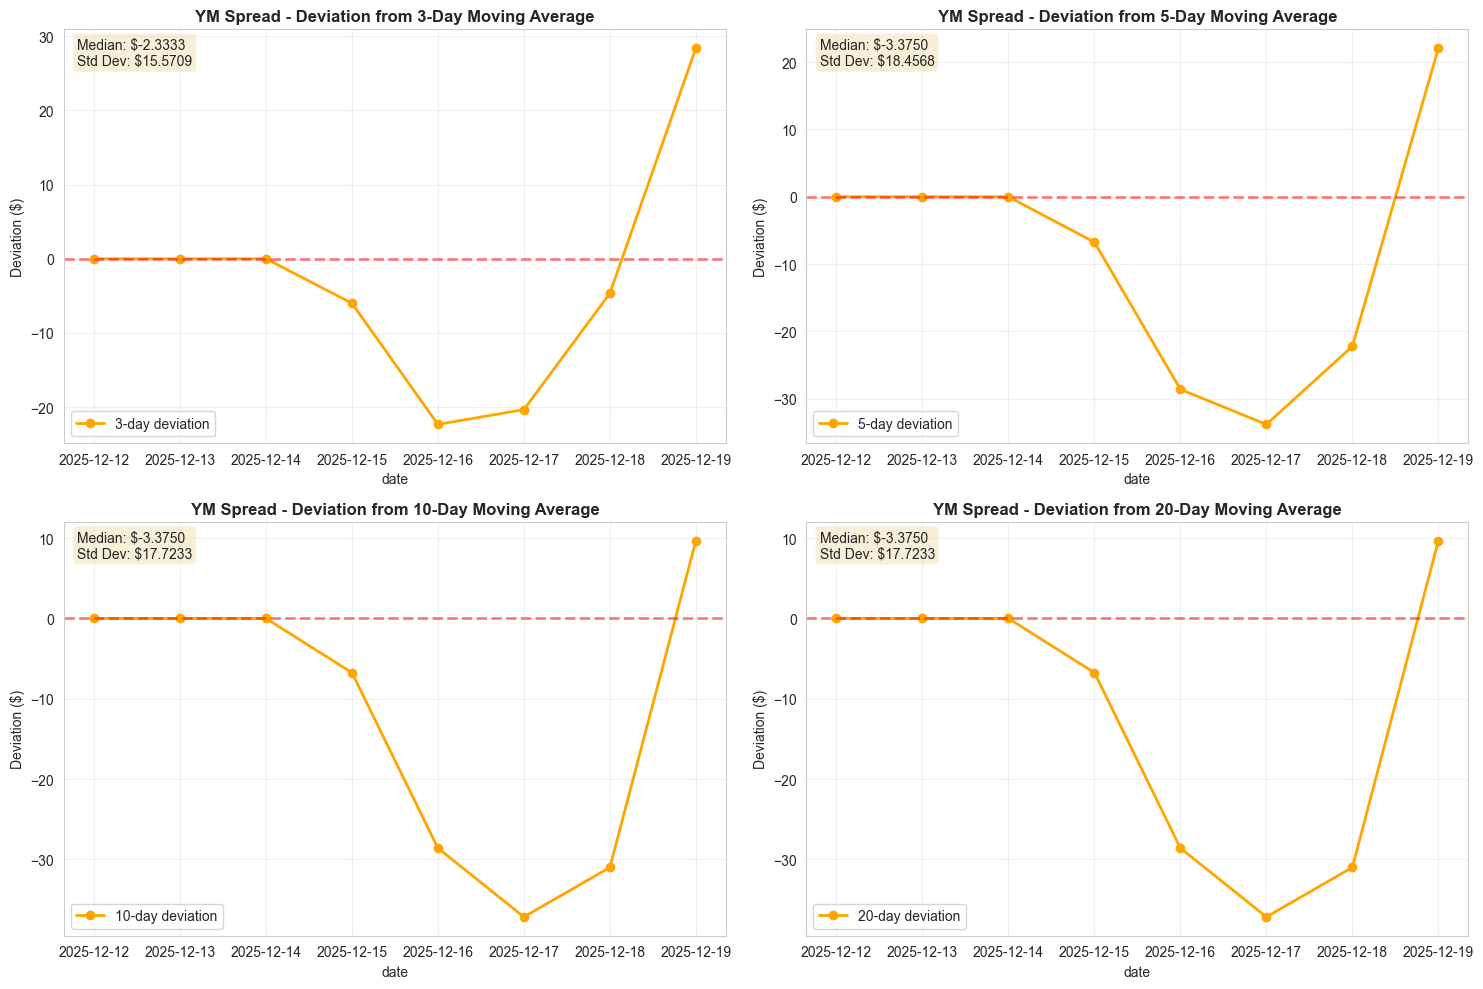


💾 Figure saved as: output/spread2_deviations.png


In [17]:
if results_ym and results_ym['deviations']:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, N in enumerate(ROLLING_WINDOWS):
        if f'd_{N}' in results_ym['deviations']:
            dev_data = results_ym['deviations'][f'd_{N}']['values']
            dev_data.plot(ax=axes[idx], label=f'{N}-day deviation',
                         linewidth=2, color='orange', marker='o')
            axes[idx].axhline(0, color='red', linestyle='--', alpha=0.5, linewidth=2)
            axes[idx].set_title(f"YM Spread - Deviation from {N}-Day Moving Average",
                              fontsize=12, fontweight='bold')
            axes[idx].set_ylabel('Deviation ($)', fontsize=10)
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
            
            # Add statistics as text
            stats_text = f"Median: ${results_ym['deviations'][f'd_{N}']['median']:.4f}\n"
            stats_text += f"Std Dev: ${results_ym['deviations'][f'd_{N}']['std']:.4f}"
            axes[idx].text(0.02, 0.98, stats_text, transform=axes[idx].transAxes,
                          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('output/spread2_deviations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n💾 Figure saved as: output/spread2_deviations.png")

### Interpretation:
- Similar to CL, but for the YM (Dow Mini) spread
- Compare the volatility of deviations across different window sizes
- Larger deviations suggest greater potential for mean reversion trades

## 16. Cross-Spread Correlation Analysis

Analyze the relationship between the two spreads.

In [18]:
print("="*80)
print("CROSS-SPREAD CORRELATION ANALYSIS")
print("="*80)

if cross_results['correlation'] is not None:
    print(f"\nCorrelation between CL and YM spreads: {cross_results['correlation']:.6f}")
    
    print("\nCorrelations between deviation values:")
    for dev_key, corr in cross_results['d_correlations'].items():
        N = dev_key.split('_')[1]
        print(f"  {N}-day deviations: {corr:.6f}")
    
    # Interpretation
    print("\n" + "-"*80)
    print("INTERPRETATION:")
    print("-"*80)
    corr_val = cross_results['correlation']
    if abs(corr_val) < 0.3:
        print(f"The correlation of {corr_val:.4f} suggests WEAK or NO LINEAR relationship")
        print("between CL and YM spreads. The two markets move relatively independently.")
    elif abs(corr_val) < 0.7:
        print(f"The correlation of {corr_val:.4f} suggests MODERATE relationship")
        print("between CL and YM spreads.")
    else:
        print(f"The correlation of {corr_val:.4f} suggests STRONG relationship")
        print("between CL and YM spreads.")

CROSS-SPREAD CORRELATION ANALYSIS

Correlation between CL and YM spreads: -0.052992

Correlations between deviation values:
  3-day deviations: 0.044248
  5-day deviations: -0.160706
  10-day deviations: -0.007307
  20-day deviations: -0.007307

--------------------------------------------------------------------------------
INTERPRETATION:
--------------------------------------------------------------------------------
The correlation of -0.0530 suggests WEAK or NO LINEAR relationship
between CL and YM spreads. The two markets move relatively independently.


## 17. Scatter Plot of Spreads

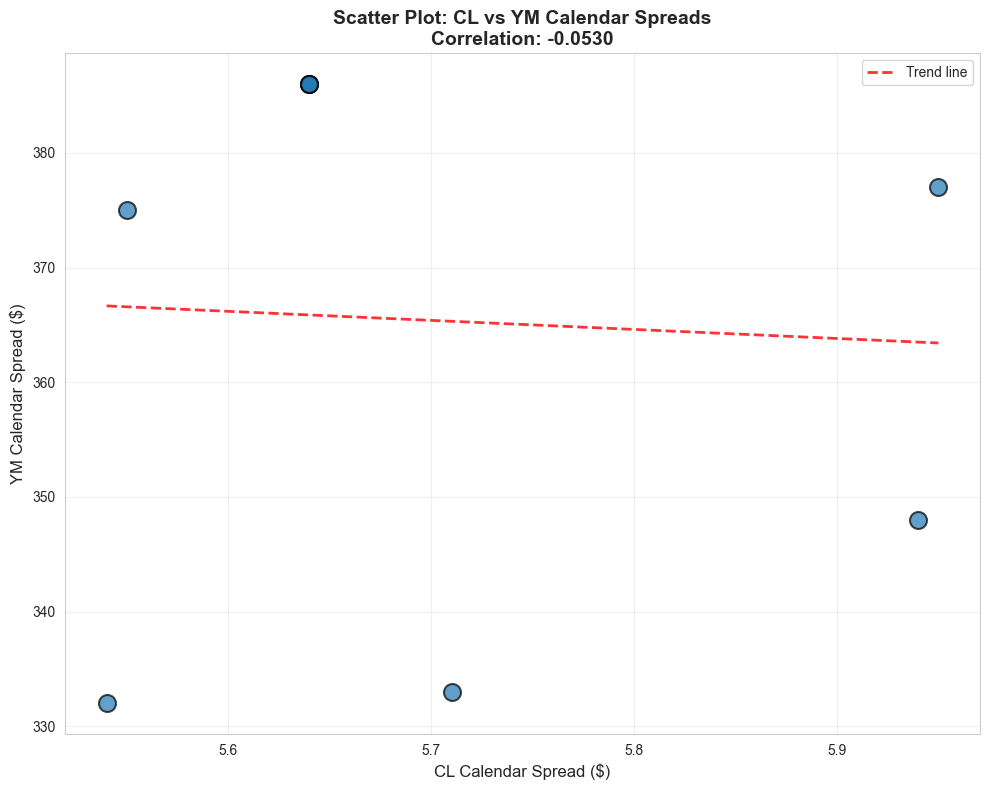


💾 Figure saved as: output/spreads_scatter.png


In [19]:
if results_cl and results_ym and cross_results['correlation'] is not None:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Scatter plot
    ax.scatter(results_cl['spread'], results_ym['spread'], 
              alpha=0.7, s=150, edgecolors='black', linewidths=1.5)
    
    # Add trend line
    z = np.polyfit(results_cl['spread'].dropna(), results_ym['spread'].dropna(), 1)
    p = np.poly1d(z)
    x_line = np.linspace(results_cl['spread'].min(), results_cl['spread'].max(), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label='Trend line')
    
    ax.set_xlabel('CL Calendar Spread ($)', fontsize=12)
    ax.set_ylabel('YM Calendar Spread ($)', fontsize=12)
    ax.set_title(f"Scatter Plot: CL vs YM Calendar Spreads\n" +
                f"Correlation: {cross_results['correlation']:.4f}",
                fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('output/spreads_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n💾 Figure saved as: output/spreads_scatter.png")

### Interpretation:
- Each point represents a day in the analysis period
- The red dashed line shows the trend
- Correlation coefficient indicates the strength of linear relationship
- Scatter indicates diversification potential between energy and equity index spreads

## 18. Detailed Deviation Statistics

### CL Spread - Deviation Statistics

In [20]:
if results_cl:
    print("="*80)
    print("CL SPREAD - DEVIATION ANALYSIS")
    print("="*80)
    
    for N in ROLLING_WINDOWS:
        dev_key = f'd_{N}'
        if dev_key in results_cl['deviations']:
            print(f"\n{N}-Day Rolling Average Deviation:")
            print(f"  Median:  ${results_cl['deviations'][dev_key]['median']:.6f}")
            print(f"  Std Dev: ${results_cl['deviations'][dev_key]['std']:.6f}")
            print("  Quantiles:")
            for q, val in results_cl['deviations'][dev_key]['quantiles'].items():
                print(f"    {q*100:5.1f}%: ${val:.6f}")

CL SPREAD - DEVIATION ANALYSIS

3-Day Rolling Average Deviation:
  Median:  $0.000000
  Std Dev: $0.135060
  Quantiles:
      1.0%: $-0.254600
      5.0%: $-0.193000
     25.0%: $-0.027500
     50.0%: $0.000000
     75.0%: $0.024167
     95.0%: $0.168167
     99.0%: $0.198967

5-Day Rolling Average Deviation:
  Median:  $0.000000
  Std Dev: $0.153028
  Quantiles:
      1.0%: $-0.201020
      5.0%: $-0.197100
     25.0%: $-0.081500
     50.0%: $0.000000
     75.0%: $0.044500
     95.0%: $0.213425
     99.0%: $0.228685

10-Day Rolling Average Deviation:
  Median:  $0.000000
  Std Dev: $0.142696
  Quantiles:
      1.0%: $-0.182638
      5.0%: $-0.173187
     25.0%: $-0.047455
     50.0%: $0.000000
     75.0%: $0.044500
     95.0%: $0.213425
     99.0%: $0.228685

20-Day Rolling Average Deviation:
  Median:  $0.000000
  Std Dev: $0.142696
  Quantiles:
      1.0%: $-0.182638
      5.0%: $-0.173187
     25.0%: $-0.047455
     50.0%: $0.000000
     75.0%: $0.044500
     95.0%: $0.213425
     

### YM Spread - Deviation Statistics

In [21]:
if results_ym:
    print("="*80)
    print("YM SPREAD - DEVIATION ANALYSIS")
    print("="*80)
    
    for N in ROLLING_WINDOWS:
        dev_key = f'd_{N}'
        if dev_key in results_ym['deviations']:
            print(f"\n{N}-Day Rolling Average Deviation:")
            print(f"  Median:  ${results_ym['deviations'][dev_key]['median']:.6f}")
            print(f"  Std Dev: ${results_ym['deviations'][dev_key]['std']:.6f}")
            print("  Quantiles:")
            for q, val in results_ym['deviations'][dev_key]['quantiles'].items():
                print(f"    {q*100:5.1f}%: ${val:.6f}")

YM SPREAD - DEVIATION ANALYSIS

3-Day Rolling Average Deviation:
  Median:  $-2.333333
  Std Dev: $15.570902
  Quantiles:
      1.0%: $-22.193333
      5.0%: $-21.633333
     25.0%: $-9.583333
     50.0%: $-2.333333
     75.0%: $0.000000
     95.0%: $18.442667
     99.0%: $26.387200

5-Day Rolling Average Deviation:
  Median:  $-3.375000
  Std Dev: $18.456787
  Quantiles:
      1.0%: $-33.436000
      5.0%: $-31.980000
     25.0%: $-23.800000
     50.0%: $-3.375000
     75.0%: $0.000000
     95.0%: $14.331200
     99.0%: $20.504640

10-Day Rolling Average Deviation:
  Median:  $-3.375000
  Std Dev: $17.723326
  Quantiles:
      1.0%: $-36.735000
      5.0%: $-35.008333
     25.0%: $-29.200000
     50.0%: $-3.375000
     75.0%: $0.000000
     95.0%: $6.290375
     99.0%: $9.000075

20-Day Rolling Average Deviation:
  Median:  $-3.375000
  Std Dev: $17.723326
  Quantiles:
      1.0%: $-36.735000
      5.0%: $-35.008333
     25.0%: $-29.200000
     50.0%: $-3.375000
     75.0%: $0.000000


## 19. Generate Comprehensive Text Report

In [22]:
# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)

# Generate report
report_path = 'output/analysis_report.txt'

with open(report_path, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("FUTURES SPREAD DYNAMICS ANALYSIS\n")
    f.write("Dafu Zhu - Student ID: 12504076\n")
    f.write(f"Analysis Period: {START_DATE} to {END_DATE}\n")
    f.write("=" * 80 + "\n\n")
    
    # CL Analysis
    if results_cl:
        f.write(f"\n{'='*80}\n")
        f.write(f"PAIR 1: {results_cl['label']}\n")
        f.write(f"{'='*80}\n\n")
        
        f.write("Basic Statistics:\n")
        f.write(f"  Mean:     {results_cl['stats']['mean']:.6f}\n")
        f.write(f"  Median:   {results_cl['stats']['median']:.6f}\n")
        f.write(f"  Std Dev:  {results_cl['stats']['std']:.6f}\n")
        f.write(f"  Min:      {results_cl['stats']['min']:.6f}\n")
        f.write(f"  Max:      {results_cl['stats']['max']:.6f}\n\n")
        
        f.write("Quantiles:\n")
        for q, val in results_cl['stats']['quantiles'].items():
            f.write(f"  {q*100:5.1f}%: {val:.6f}\n")
        
        f.write("\n" + "-"*80 + "\n")
        f.write("Deviation Analysis (from N-day Rolling Average):\n")
        f.write("-"*80 + "\n")
        
        for N in ROLLING_WINDOWS:
            dev_key = f'd_{N}'
            if dev_key in results_cl['deviations']:
                f.write(f"\n{N}-Day Rolling Average Deviation:\n")
                f.write(f"  Median: {results_cl['deviations'][dev_key]['median']:.6f}\n")
                f.write(f"  Std Dev: {results_cl['deviations'][dev_key]['std']:.6f}\n")
                f.write("  Quantiles:\n")
                for q, val in results_cl['deviations'][dev_key]['quantiles'].items():
                    f.write(f"    {q*100:5.1f}%: {val:.6f}\n")
    
    # YM Analysis
    if results_ym:
        f.write(f"\n\n{'='*80}\n")
        f.write(f"PAIR 2: {results_ym['label']}\n")
        f.write(f"{'='*80}\n\n")
        
        f.write("Basic Statistics:\n")
        f.write(f"  Mean:     {results_ym['stats']['mean']:.6f}\n")
        f.write(f"  Median:   {results_ym['stats']['median']:.6f}\n")
        f.write(f"  Std Dev:  {results_ym['stats']['std']:.6f}\n")
        f.write(f"  Min:      {results_ym['stats']['min']:.6f}\n")
        f.write(f"  Max:      {results_ym['stats']['max']:.6f}\n\n")
        
        f.write("Quantiles:\n")
        for q, val in results_ym['stats']['quantiles'].items():
            f.write(f"  {q*100:5.1f}%: {val:.6f}\n")
        
        f.write("\n" + "-"*80 + "\n")
        f.write("Deviation Analysis (from N-day Rolling Average):\n")
        f.write("-"*80 + "\n")
        
        for N in ROLLING_WINDOWS:
            dev_key = f'd_{N}'
            if dev_key in results_ym['deviations']:
                f.write(f"\n{N}-Day Rolling Average Deviation:\n")
                f.write(f"  Median: {results_ym['deviations'][dev_key]['median']:.6f}\n")
                f.write(f"  Std Dev: {results_ym['deviations'][dev_key]['std']:.6f}\n")
                f.write("  Quantiles:\n")
                for q, val in results_ym['deviations'][dev_key]['quantiles'].items():
                    f.write(f"    {q*100:5.1f}%: {val:.6f}\n")
    
    # Cross-pair analysis
    if cross_results:
        f.write(f"\n\n{'='*80}\n")
        f.write("CROSS-SPREAD ANALYSIS\n")
        f.write(f"{'='*80}\n\n")
        
        f.write(f"Correlation between spreads: {cross_results['correlation']:.6f}\n\n")
        
        f.write("Correlations between deviation values:\n")
        for dev_key, corr in cross_results['d_correlations'].items():
            N = dev_key.split('_')[1]
            f.write(f"  {N}-day deviations: {corr:.6f}\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write("END OF REPORT\n")
    f.write("="*80 + "\n")

print(f"\n✓ Comprehensive report saved as: {report_path}")


✓ Comprehensive report saved as: output/analysis_report.txt


## 20. Summary and Conclusions

In [23]:
print("="*80)
print("ANALYSIS SUMMARY")
print("="*80)

print("\n📊 Generated Files:")
print("  1. spreads_timeseries.png - Time series of both calendar spreads")
print("  2. spreads_distribution.png - Distribution histograms")
print("  3. spread1_deviations.png - CL deviation from moving averages")
print("  4. spread2_deviations.png - YM deviation from moving averages")
print("  5. spreads_scatter.png - Correlation scatter plot")
print("  6. analysis_report.txt - Comprehensive text report")

print("\n📈 Key Findings:")

if results_cl:
    print(f"\n  CL (Crude Oil) Calendar Spread:")
    print(f"    - Mean: ${results_cl['stats']['mean']:.2f}")
    print(f"    - Std Dev: ${results_cl['stats']['std']:.2f}")
    print(f"    - Range: ${results_cl['stats']['min']:.2f} to ${results_cl['stats']['max']:.2f}")

if results_ym:
    print(f"\n  YM (Dow Mini) Calendar Spread:")
    print(f"    - Mean: ${results_ym['stats']['mean']:.2f}")
    print(f"    - Std Dev: ${results_ym['stats']['std']:.2f}")
    print(f"    - Range: ${results_ym['stats']['min']:.2f} to ${results_ym['stats']['max']:.2f}")

if cross_results['correlation'] is not None:
    print(f"\n  Cross-Spread Relationship:")
    print(f"    - Correlation: {cross_results['correlation']:.4f}")
    if abs(cross_results['correlation']) < 0.3:
        print(f"    - Interpretation: Weak/No linear relationship - good diversification")

print("\n" + "="*80)
print("✓ ANALYSIS COMPLETE")
print("="*80)

ANALYSIS SUMMARY

📊 Generated Files:
  1. spreads_timeseries.png - Time series of both calendar spreads
  2. spreads_distribution.png - Distribution histograms
  3. spread1_deviations.png - CL deviation from moving averages
  4. spread2_deviations.png - YM deviation from moving averages
  5. spreads_scatter.png - Correlation scatter plot
  6. analysis_report.txt - Comprehensive text report

📈 Key Findings:

  CL (Crude Oil) Calendar Spread:
    - Mean: $5.70
    - Std Dev: $0.16
    - Range: $5.54 to $5.95

  YM (Dow Mini) Calendar Spread:
    - Mean: $365.38
    - Std Dev: $23.81
    - Range: $332.00 to $386.00

  Cross-Spread Relationship:
    - Correlation: -0.0530
    - Interpretation: Weak/No linear relationship - good diversification

✓ ANALYSIS COMPLETE


In [24]:
# Close the database connection
db.close()
print("✓ WRDS connection closed")

✓ WRDS connection closed
